# Aquarium Styles Classifier

---

# Table of Contents 

- [Data Analysis](#Data-Analysis)
  - [Data visualization](#Data-visualization)
  - [Data Augmentation](#Data-Augmentation)
  - [Dataset](#Dataset)
- [CNN Model](#CNN-Model)
  - [Training](#Training)
  - [Evaluation](#Evaluation)
- [Conclusion](#Conclusion)

---

In [1]:
# for google colab

# !pip install torchmetrics
# !pip install torchinfo
# !pip install mlxtend

In [2]:
import torch
from torch import nn
torch.__version__

'2.1.1+cpu'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Data Analysis

In [4]:
from pathlib import Path
import os
import requests
import zipfile
from typing import List, Tuple, Dict

In [5]:
dataset_dir = Path('../datasets/aquarium')
dataset_dir.mkdir(parents=True, exist_ok=True)

In [6]:
def isEmpty(dir: Path):
    return not any(dir.iterdir())
    
if not isEmpty(dataset_dir):
    print('Dataset exists')
else:
    print('Downloading dataset...')
    with open('./aquarium-styles-dataset.zip', 'wb') as f:
        request = requests.get('https://github.com/JeryBan/aquarium-styles-classifier/raw/main/aquarium-styles-dataset.zip')
        f.write(request.content)

    print('Unzipping...')
    with zipfile.ZipFile('aquarium-styles-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
        print('Done')
        

Dataset exists


In [7]:
total_images = 0
for root, dirs, files in os.walk(dataset_dir):
    if len(dirs): print(f'There are {len(dirs)} directories in {root} -> {dirs}')
    total_images += len(files)
print(f'Total number of images: {total_images}')

There are 2 directories in ../datasets/aquarium -> ['test', 'train']
There are 3 directories in ../datasets/aquarium/test -> ['jungle', 'japanese', 'dutch']
There are 3 directories in ../datasets/aquarium/train -> ['jungle', 'japanese', 'dutch']
Total number of images: 216


In [8]:
train_dir = dataset_dir / 'train'
test_dir = dataset_dir / 'test'

## Data visualization

In [9]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
image_path_list = list(dataset_dir.glob('*/*/*.jpg'))
image_path_list[:3]

[PosixPath('../datasets/aquarium/test/jungle/jungle_4.jpg'),
 PosixPath('../datasets/aquarium/test/jungle/vfr.jpg'),
 PosixPath('../datasets/aquarium/test/jungle/ADSasd.jpg')]

In [11]:
def display_images(image_paths: List[str]):
    '''Displays a random image and its attributes from a list of image paths.'''

    if not image_paths: return 'List is empty'
        
    img_path = random.choice(image_paths)
    class_name = img_path.parent.stem
    img = Image.open(img_path)
    
    print(f'Path: {img_path}')
    print(f'Class: {class_name}')
    print(f'Width: {img.width}, Height: {img.height}')
    
    return img 
    

Path: ../datasets/aquarium/train/dutch/zwzxx.jpg
Class: dutch
Width: 416, Height: 121


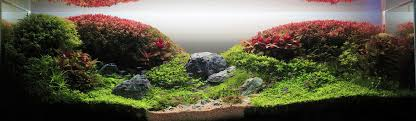

In [12]:
display_images(image_path_list)

## Data Augmentation
Since the dataset is small we will apply some data augmentation techniques to help our model. Aquarium styles differ with each other mostly in color rather by shape (especially dutch and jungle styles). Thats why we select transformations that enhance that feature. Moreover notice after we apply some transformations how the result image (in most cases) looks just like a new aquarium. We take advantage of that characteristic to virtually increase our training dataset.

In [13]:
import torchvision
from torchvision.transforms import v2

In [14]:
TARGET_SIZE = (256, 256)

train_transformations = v2.Compose([
    v2.RandomChoice([
        v2.CenterCrop(size=128),
        v2.RandomPerspective(distortion_scale=0.5, p=1)
    ], p=[7, 3]),
    v2.Resize(size=TARGET_SIZE),
    v2.RandomChoice([
        v2.RandomHorizontalFlip(p=1),
        v2.RandomVerticalFlip(p=1)
    ],p=[7, 3]),
    v2.ColorJitter(brightness=(1.3, 1.8), saturation=(1.5, 2)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

test_transformations = v2.Compose([
    v2.Resize(size=TARGET_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

Lets visualize our transformations

In [15]:
def compare_transformed_images(image_paths: List[str],
                              transformation: torchvision.transforms):
    '''Compares original images to their transformed counterpart'''
    
    random_paths = random.sample(image_paths, k=3)

    for path in random_paths:
        with Image.open(path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            
            # Original image
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nsize: {f.size}')
            ax[0].axis(False)

            # Transformed image
            f = transformation(f)
            ax[1].imshow(f.permute(1, 2, 0))
            ax[1].set_title(f'Transformed\nshape: {f.shape}')
            ax[1].axis(False)
            
            fig.suptitle(f'Class: {path.parent.stem}')

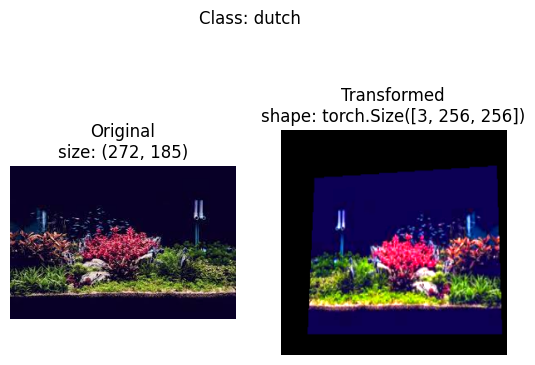

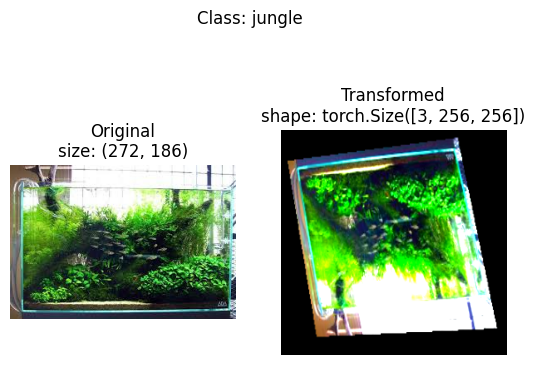

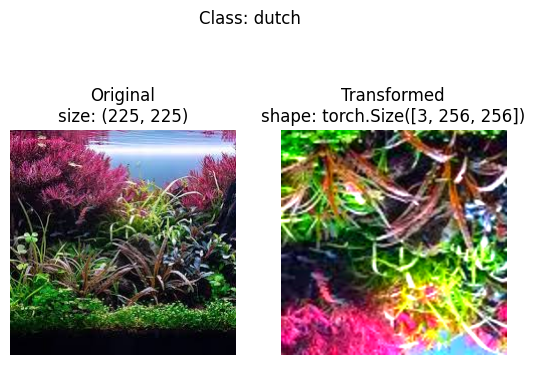

In [16]:
compare_transformed_images(image_path_list, train_transformations)

# Dataset

In [17]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [18]:
train_dataset = ImageFolder(root=train_dir, transform=train_transformations)

test_dataset = ImageFolder(root=test_dir, transform=test_transformations)

In [19]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 156
    Root location: ../datasets/aquarium/train
    StandardTransform
Transform: Compose(
                 RandomChoice(transforms=[CenterCrop(size=(128, 128)), RandomPerspective(p=1, distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, fill=0)], p=[0.7, 0.3])
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomChoice(transforms=[RandomHorizontalFlip(p=1), RandomVerticalFlip(p=1)], p=[0.7, 0.3])
                 ColorJitter(brightness=(1.3, 1.8), saturation=(1.5, 2.0))
                 ToImage()
                 ToDtype(scale=True)
           )

In [20]:
len(train_dataset), len(test_dataset)

(156, 60)

In [21]:
train_dataset.classes

['dutch', 'japanese', 'jungle']

In [22]:
def display_random_images(target_dataset: torchvision.datasets, classes: List[str]=train_dataset.classes):
    '''Display random images from the target dataset'''

    random_sample_idx = random.sample(range(len(target_dataset)), k=6)

    plt.figure(figsize=(12,7))
    nrows, ncols = 2, 3

    for i, sample in enumerate(random_sample_idx):
        img, label = target_dataset[sample][0], target_dataset[sample][1]
        
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(classes[label])
        plt.axis(False)

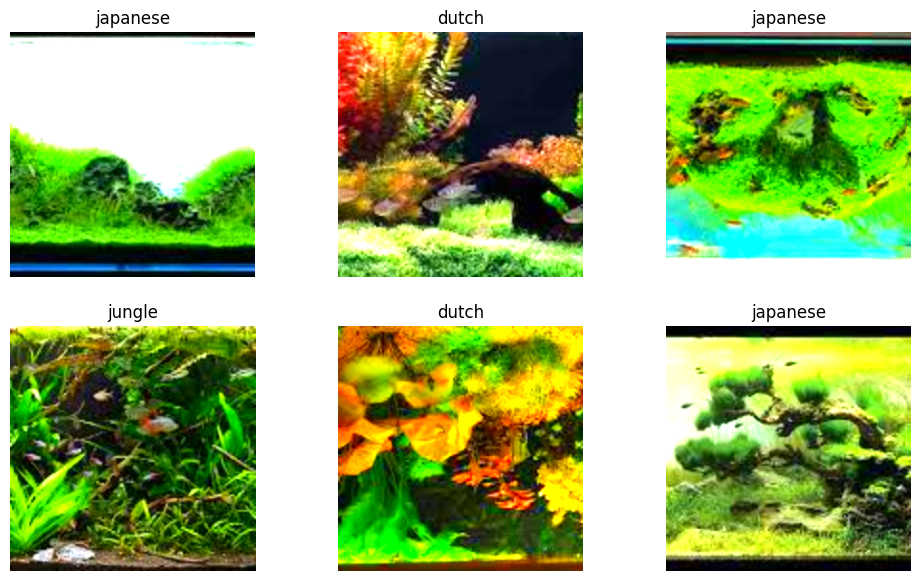

In [23]:
display_random_images(target_dataset=train_dataset)

In [24]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False)

# CNN Model

Simpler models have fewer parameters, which makes them less prone to overfitting, especially when dealing with small datasets. Complex models may have a higher risk of overfitting because they can learn to memorize the training data instead of generalizing from it. As far as our CNN model goes we will try to keep it simple for that reason.

In [25]:
from torch.optim.lr_scheduler import LambdaLR

from torchmetrics import Accuracy
from torchinfo import summary

acc_fn = Accuracy(task='multiclass', num_classes=len(train_dataset.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()

In [50]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape, 
                                                    out_channels=hidden_units,
                                                    kernel_size=5,
                                                    stride=1,
                                                    padding=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2),
                                          nn.Dropout())

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.ReLU(),
                                        nn.Linear(in_features=hidden_units*127*127,
                                                  out_features=output_shape))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        #print(x.shape)
        return self.classifier(x)

In [51]:
demo_model = CNNModel(input_shape=3, 
                     hidden_units=16, 
                     output_shape=len(train_dataset.classes)
                  ).to(device)

optimizer = torch.optim.SGD(demo_model.parameters(), lr=0.01)

In [52]:
test_img, test_label = next(iter(train_dataloader))

In [53]:
demo_model(test_img.to(device))

tensor([[ 0.2449,  0.1081,  0.0338],
        [ 0.0223,  0.0332, -0.0100],
        [ 0.1885,  0.2627,  0.0917],
        [ 0.2192,  0.5251,  0.3953],
        [-0.0739,  0.2140,  0.0055],
        [-0.1683,  0.1718,  0.0789],
        [ 0.1097,  0.0269,  0.1186],
        [-0.0529, -0.1986,  0.0791],
        [-0.0354, -0.0064,  0.2330],
        [-0.0493,  0.0295,  0.1327],
        [ 0.0404,  0.0150,  0.3294],
        [-0.2622,  0.0560, -0.1240],
        [-0.1044,  0.1380,  0.1863],
        [-0.0977, -0.1605,  0.2470],
        [-0.2738,  0.0421,  0.2739],
        [-0.0142,  0.0097,  0.0960]], grad_fn=<AddmmBackward0>)

In [54]:
summary(demo_model, input_data=test_img.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [16, 3]                   --
├─Sequential: 1-1                        [16, 16, 127, 127]        --
│    └─Conv2d: 2-1                       [16, 16, 254, 254]        1,216
│    └─ReLU: 2-2                         [16, 16, 254, 254]        --
│    └─MaxPool2d: 2-3                    [16, 16, 127, 127]        --
│    └─Dropout: 2-4                      [16, 16, 127, 127]        --
├─Sequential: 1-2                        [16, 3]                   --
│    └─Flatten: 2-5                      [16, 258064]              --
│    └─ReLU: 2-6                         [16, 258064]              --
│    └─Linear: 2-7                       [16, 3]                   774,195
Total params: 775,411
Trainable params: 775,411
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.27
Input size (MB): 12.58
Forward/backward pass size (MB): 132.13
Params size (MB): 3.10
Estimated Total Siz

In [55]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               acc_fn = acc_fn,
               device = device):

    model.to(device)
    model.train()

    train_loss, train_acc = 0, 0

    for X,y in dataloader:
        X, y = X.to(device), y.to(device)

        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += acc_fn(y_pred, y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc = (train_acc / len(dataloader)) *100

    return train_loss, train_acc

In [56]:
def test_step(model: nn.Module,
               dataloader: torch.utils.data,
               loss_fn: nn.Module,
               acc_fn = acc_fn,
               device = device):

    model.to(device)
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)

            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(test_logits, y).item()
            test_acc += acc_fn(test_pred, y).item()

        test_loss /= len(dataloader)
        test_acc = (test_acc /  len(dataloader)) * 100 

    return test_loss, test_acc
    

In [57]:
def training(epochs: int, 
            model: nn.Module,
            train_dataloader: torch.utils.data,
            test_dataloader: torch.utils.data,
            loss_fn: nn.Module,
            optimizer: torch.optim,
            acc_fn = acc_fn,
            device = device):

    results = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }

    best_test_loss = float('inf')

    for epoch in range(epochs):

        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)

        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        if test_loss < best_test_loss:
          best_test_loss = test_loss
          torch.save(obj=model.state_dict(), f=MODEL_PATH)

        scheduler.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}\n-------')
            print(f'Train loss: {train_loss:.4f} | test loss: {test_loss:.4f}')
            print(f'Train acc: {train_acc:.2f}% | test acc: {test_acc:.2f}%\n')

    model_0.load_state_dict(torch.load(f=MODEL_PATH))
    model_0.to(device)
    return results                                   

    

## Training

In [58]:
SAVE_PATH = Path('../saved_models')
NAME = 'aquarium-classifier-best.pth'
MODEL_PATH = SAVE_PATH / NAME
SAVE_PATH.mkdir(parents=True, exist_ok=True)

INPUT_SHAPE = 3
HIDDEN_UNITS = 32
OUTPUT_SHAPE = len(train_dataset.classes)

model_0 = CNNModel(input_shape=INPUT_SHAPE, 
                     hidden_units=HIDDEN_UNITS, 
                     output_shape=OUTPUT_SHAPE
                  ).to(device)

In [59]:
EPOCHS = 50
lr = 0.001

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr, weight_decay=0.05)
scheduler = LambdaLR(optimizer=optimizer, 
                     lr_lambda= lambda epoch: 0.95 ** (epoch - 15) if (epoch > 15) else 1.0)

weights = torch.tensor([1.3, 1, 1], dtype=torch.float, device=device)
loss_fn = nn.CrossEntropyLoss(weight=weights)

acc_fn = Accuracy(task='multiclass', num_classes=len(train_dataset.classes)).to(device)


In [60]:
results_0 = training(epochs=EPOCHS,
                    model=model_0,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    acc_fn=acc_fn,
                    device=device)

Epoch: 0
-------
Train loss: 10.2580 | test loss: 2.5877
Train acc: 45.00% | test acc: 60.94%

Epoch: 10
-------
Train loss: 0.3026 | test loss: 0.4475
Train acc: 90.00% | test acc: 89.06%

Epoch: 20
-------
Train loss: 0.2559 | test loss: 0.3334
Train acc: 90.42% | test acc: 85.42%

Epoch: 30
-------
Train loss: 0.1847 | test loss: 0.3342
Train acc: 95.00% | test acc: 85.42%

Epoch: 40
-------
Train loss: 0.1514 | test loss: 0.3548
Train acc: 94.17% | test acc: 88.54%



## Evaluation

In [61]:
def plot_results(results: Dict):
    '''Loss and accuracy values plot comparison from the training'''
    
    if results:
        train_loss = results["train_loss"]
        test_loss = results["test_loss"]
        train_acc = results["train_acc"]
        test_acc = results["test_acc"]
        epoch = range(len(train_loss))
        
        plt.figure(figsize=(10, 7))
        
        plt.subplot(1, 2, 1)
        plt.plot(epoch, train_loss, label='train loss')
        plt.plot(epoch, test_loss, label='test loss')
        plt.xlabel('Epochs')
        plt.ylim(0, 3)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epoch, train_acc, label='train acc')
        plt.plot(epoch, test_acc, label='test acc')
        plt.xlabel('Epochs')
        plt.legend()


In [62]:
def get_predictions(model: nn.Module,
                     data = test_dataloader,
                     device: torch.device = device):
    '''Get predictions from the trained model'''
    
    predictions = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X,y in data:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            pred = torch.softmax(logits, dim=1).argmax(dim=1)
            predictions.append(pred)

    return torch.cat(predictions)        
                                      

In [63]:
pd.DataFrame(results_0)

,train_loss,train_acc,test_loss,test_acc
0,10.258027,45.000000,2.587704,60.937500
1,1.877558,64.583333,1.123291,61.979167
2,0.965151,71.458333,0.506600,76.562500
3,0.685486,81.041667,0.655293,69.270834
4,0.789177,75.416667,0.532104,82.291667
5,0.574822,77.500000,0.552587,75.520833
6,0.545566,79.166667,0.606140,71.354166
7,0.544004,83.750000,0.506941,78.645833
8,0.392894,84.375000,0.719872,69.270833
9,0.548470,81.250000,0.625901,65.625000


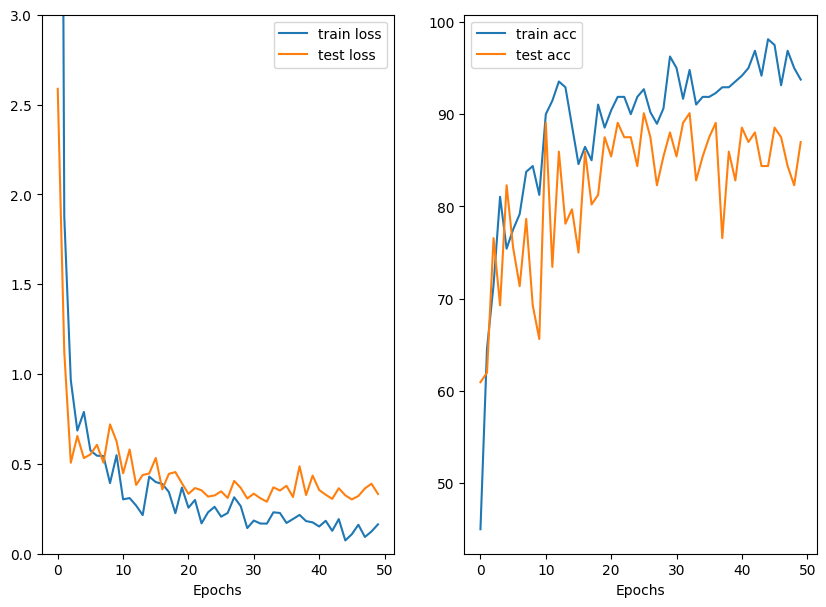

In [64]:
# plot training results
plot_results(results_0)

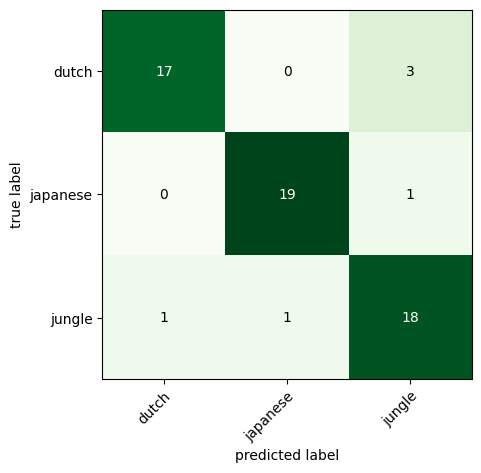

In [65]:
# plot confusion matrix with our best model
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat_fn = ConfusionMatrix(task='multiclass', num_classes=len(test_dataset.classes))

predictions = get_predictions(model_0)
confmat_tensor = confmat_fn(preds=predictions.cpu(), target=torch.Tensor(test_dataset.targets).cpu())

fig, ax = plot_confusion_matrix(
            conf_mat=confmat_tensor.numpy(),
            class_names=test_dataset.classes,
            cmap='Greens')

# Conclusion

* Tried both `torch.optim.Adam` and `torch.optim.SGD` and the former performed much better. 
* Increasing the weight of the dutch aquariums by a bit, helped the model clean some confusion between dutch and jungle targets.
* Adding a Dropout layer after the Convolutional block was key to reduce the overfiting of the model.
* To take advantage of the color differences between the three styles i opted for a ColorJitter transformation instead of a Normalize one.
* Going with a smaller batch size, helped a bit with the generalization of the model without having the "small batch" disadvantages since the dataset is small.